# Reinforcement Learning, Feature Spaces, and Graphs
### Kimberly Stachenfeld
### 15 August 2019
### [MIND Summer School](https://sbs.dartmouth.edu/news/methods-neuroscience-dartmouth-mind-2019-computational-summer-school-cognitive-maps)


In this tutorial we'll go through a few ideas related to reinforcement learning (RL) in environments that can be modelled as graphs. A common way to set up an RL environment is to use the Markov Decision Process (MDP) formalism: an environment consists of a set of states the agent can occupy, actions that induce transitions between states, and a reward at each state. The MDP can be described as a graph (aka network) in which the nodes of the graph correspond to states the agent can occupy and the edges of the graph connect states that are joined by some action. An RL agent might explore the graph, trying to learn which states lead to reward and not punishment.

The simplest agent might learn about each state one at a time, eventually accruing a value function in which each the expected cumulative future (usually discounted) reward is estimated one-by-one for each state. However, learning can in some cases be sped up if instead of representing each state in isolation, the agent uses a "feature representation" that captures relevant information about that state.

For the simple agent, these isolated states might be represented as "one-hot" feature vectors: state 1 = [1, 0, 0, 0], state 2 = [0, 1, 0, 0], and so on. The similarity between states 1 and 2 is 0, the similarity between state 1 and itself is 1. These "features" distinguish all different states equally, so that learning about state 1 tells you nothing about state 2.

A cleverer agent might use a structured representation that captures the relationship between states 1 and 2. If state 1 and 2 have a really similar relationship with reward, we might want to give them a similar feature representation: maybe state 1 = [1, .2, 0] and state 2 = [.9, .3, .1]. When we do RL with a representation, we're learning not how valuable each *state* is, but how valuable each *feature* is. Since state 1 and 2 have similar feature representations, whatever the agent learns about state 1 is automatically applied to state 2 because of their similar representations. 

Here we will explore representations that are sensitive to task structure in different ways. These representations will capture things like whether or not two states are predictive of similar outcomes under a random walk. We can explore how different representations and parameters affect RL and generalization for different graphical environments and different reward functions.

In [11]:
# Imports
import numpy as np
import time
import tasks
import representations
import matplotlib.pyplot as plt
import plotting
import util
import rl
import seaborn as sns

# Tasks
Each task will yield `adj`, an `n_state x n_state` "adjacency matrix" specifying which states are joined by an action (`adj[i, j] = 1` if states `i` and `j` are adjacent, 0 otherwise), `xy`, an `n_state x 2` array containing the (x, y) hard-coded coordinates of each state for plotting the graph, and `labels`, a hard-coded label for each node specifying cluster membership (if applicable -- for graphs without community structure, this will be 0 everywhere).
- **line**: `n_line` states connected in a line.
- **ring**: `n_ring` states connected in a ring.
- **openroom**: `dims_openroom[0] x dims_openroom[1]` states connected in a rectangular mesh. Good for simulating spatial tasks.
- **fourrooms**: `dims_fourrooms[0] x dims_fourrooms[1]` states connected in a rectangular mesh, interrupted by boundaries dividing the rectangle into four rooms with "doorway" edges connecting these rooms. Good for simulating spatial tasks with compartment or clustered structure.
- **clique**: `n_clique` states, each of which is connected to every other.
- **clique_ring**: `n_cluster_clqrng` almost-cliques, all connected to each other in a ring. Each clique contains `n_in_cluster_clqrng` states. I'm saying "almost-cliques" because each clique is missing one edge that connects the two externally connectd states that join one clique to the previous/next in the ring. This means every state in the graph has constant degree (aka number of neighbors). Good for seeing what happens with cluster/community structure and rotational symmetry.
- **tower_of_hanoi**: this is the graph governing transitions in the 3-disk ["Tower of Hanoi" puzzle](https://en.wikipedia.org/wiki/Tower_of_Hanoi). Each state corresponds to a permitted configuration of disks arranged on pegs. If you plot the graph, you'll see a sort of clustered, recursive triangle. Note that the vertices of this triangle correspond to configurations where all the disks are on a single peg, and the edges that connect different clusters correspond to moving the largest disk. Also good for seeing what happens with cluster/community structure and rotational symmetry. No params (`num_disks` could have been a parameter for the n-disk Tower of Hanoi, but I haven't coded it up :).
- **tree**: a tree with depth `tree_depth` in which each node branches into `tree_n_branch` branches. Good for seeing what happens with hierarchically organized task spaces.
- **stochastic_block_model**: a model for generating stochastic random graphs with clustered community structure. The graph will have `n_clu_sbm` clusters, each of which will have `n_in_clu_sbm[i]` nodes, and the probability of an edge between a node in cluster i and a node in cluster j will be `p_between_cluster_sbm`. Good for looking at what happens with multicluster environments that aren't so clean and symmetric as clique_ring or tower_of_hanoi.

In [12]:
task_name = "ring"
# options: "line", "ring", "openroom", "fourrooms", "clique", "clique_ring", 
#     "tower_of_hanoi", "tree", "stochastic_block_model"

# Parameters for different environment graphs.
n_line = 32
n_ring = 32
dims_openroom = [14, 18]
dims_fourrooms = [14, 18]
n_clique = 5  # clique params
n_cluster_clqrng = 3
n_in_cluster_clqrng = 5
tree_depth = 3
tree_n_branch = 2
n_clu_sbm = 3
n_in_clu_sbm = [10, 12, 8]
p_between_cluster_sbm = .8*np.eye(3) + .1  # .9 within-cluster, .2 between cluster

# Get task graph.
if task_name == "line":
    adj, xy, labels = tasks.line(n_line)
elif task_name == "ring":
    adj, xy, labels = tasks.ring(n_ring)
elif task_name == "openroom":
    adj, xy, labels = tasks.rectangle_mesh(dims_openroom)
elif task_name == "fourrooms":
    adj, xy, labels = tasks.four_rooms(dims_fourrooms)
elif task_name == "clique":
    adj, xy, labels = tasks.clique(n_clique)
elif task_name == "clique_ring":
    adj, xy, labels = tasks.clique_ring(n_cluster_clqrng, n_in_cluster_clqrng)
elif task_name == "tower_of_hanoi":
    adj, xy, labels = tasks.tower_of_hanoi()
elif task_name == "tree":
    adj, xy, labels = tasks.tree(tree_depth, tree_n_branch, directed=False)
elif task_name == "stochastic_block_model":
    adj, xy, labels = tasks.stochastic_block(n_clu_sbm, n_in_clu_sbm, p_between_cluster_sbm)
else:
    raise ValueError("No task named {} implemented.".format(task_name))


# Visualizing the environment
Plot the graph underlying the task environment we just selected. Feel free to alter the plotting parameters if e.g. nodes are too big or small. 

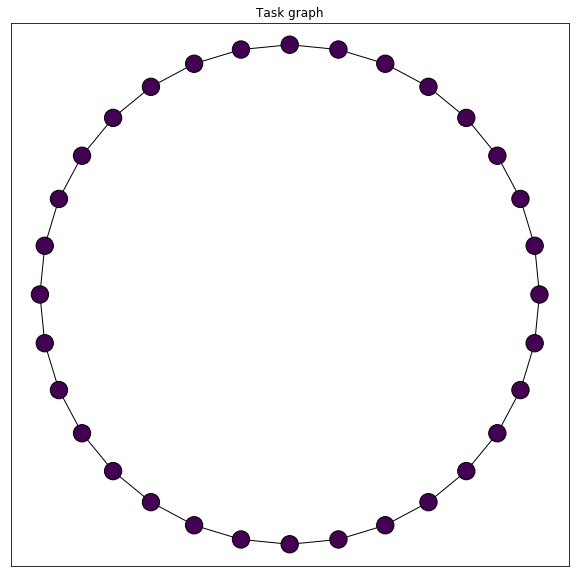

In [13]:
# Visualize task graph.
def visualize_task_graph(adj, xy, labels, node_size=100):
    _, ax = plt.subplots(1, figsize=(10, 10))
    plotting.plot_graph(adj, xy=xy, ax=ax, node_color=labels, node_size=node_size)
    _ = ax.axis("equal")
    _ = ax.set_title("Task graph")
    
visualize_task_graph(adj, xy, labels, node_size=300)


# Selecting a representation
Now we will select the features the agent will use to describe each state in the graph. 

### Representations:
- **onehot**: Each state is represented as an `n_state` one-hot vector that is 1 at the index corresponding to the state's unique label and 0 everywhere else. For instance, `rep_features[0] = [1, 0, ....]`, `rep_features[1] = [0, 1, 0, ....]`, etc.
- **successor_rep_randwalk**:  Each state is represented as the *expected discounted future state occupancy* given that starting state under a random walk policy. `rep_features[0, 1]` contains the expected discounted number of times state 1 will be visited under a random walk starting from state 0. The discount `sr_discount` will lie between 0 and 1 and downweights states visited in the future compared to states visited sooner (a state visited at timestep t will only count as `discount**t`. The successor representation feature matrix can also be described as the discounted sum of future `t`-step random walk transition matrices `T**t`, `I + discount * T + discount**2 T**2 + ... `. Note that this successor representation assumes a random walk policy, rather than the optimal policy, and that using a different policy-specific successor representation will change results significantly.
- **laplacian_eig**: Laplacian eigenvectors capture a lot of the same information as the random walk successor representation but organize it in a different way (or, more formally, in a different basis). The first eigenvector (the one with the smallest eigenvalue) will be constant everywhere, the second (with the second-smallest eigenvalue) will be the function that varies as smoothly and slowly as possible over the graph as possible, and further eigenvectors will capture "higher frequency" information that changes more sharply over the environment. This representation can be used to dimensionally reduce the representation by taking `rep_features = rep_features[:, :n_l_eigs]`. This will make force the RL agent to learn a smoother value function by discarding components that capture more sharply varying information.
- **euclidean_gaussian**: This representation is comparable to conventional place cells. The centers of `n_gaussian_centers` gaussians with width `sigma_gaussian` are randomly selected, and each state is represented in terms of these gaussians. For instance, `rep_features[i, j]` will be proportional to the a gaussian over the distance between `xy[i]` and the center of Gaussian j.

Feel free to add your own! Maybe even push them to the github page :)

In [14]:
# Get representation.
rep_name = "laplacian_eig"
# options: "onehot", "successor_rep_randwalk", "laplacian_eig", "euclidean_gaussian"
sr_discount = .9
laplacian_norm_type = "unnorm"  # Options: "norm", "unnorm", "rw" (random walk normalized)
                                # These can lead to slightly different representations,
                                # particularly when when different nodes in the graph have very different degrees.
sigma_gaussian = 1.
n_l_eigs = len(adj)  # default len(adj): use all eigs
n_gaussian_centers = 100

if rep_name == "onehot":
    rep_features, _ = representations.state_onehot(adj)
elif rep_name == "rw_successor_rep":
    randomwalk_transmat = util.l1_normalize_rows(adj)
    rep_features, _ = representations.successor_rep(randomwalk_transmat, sr_discount)
elif rep_name == "laplacian_eig":  # unnormalized laplacian = (degree_matrix - adjacency_matrix)
    rep_features, evals = representations.laplacian_eig(adj, norm="unnorm")
    rep_features = rep_features[:, :n_l_eigs]
elif rep_name == "euclidean_gaussian":
    rep_features, centers = representations.euclidean_gaussian(xy, sigma_gaussian, None, n_gaussian_centers)
else:
    raise ValueError("No representation named {} implemented.".format(rep_name))


# Plot each feature
Each subplot will correspond to one feature dimension of the representation, evaluated for each state in the graph.

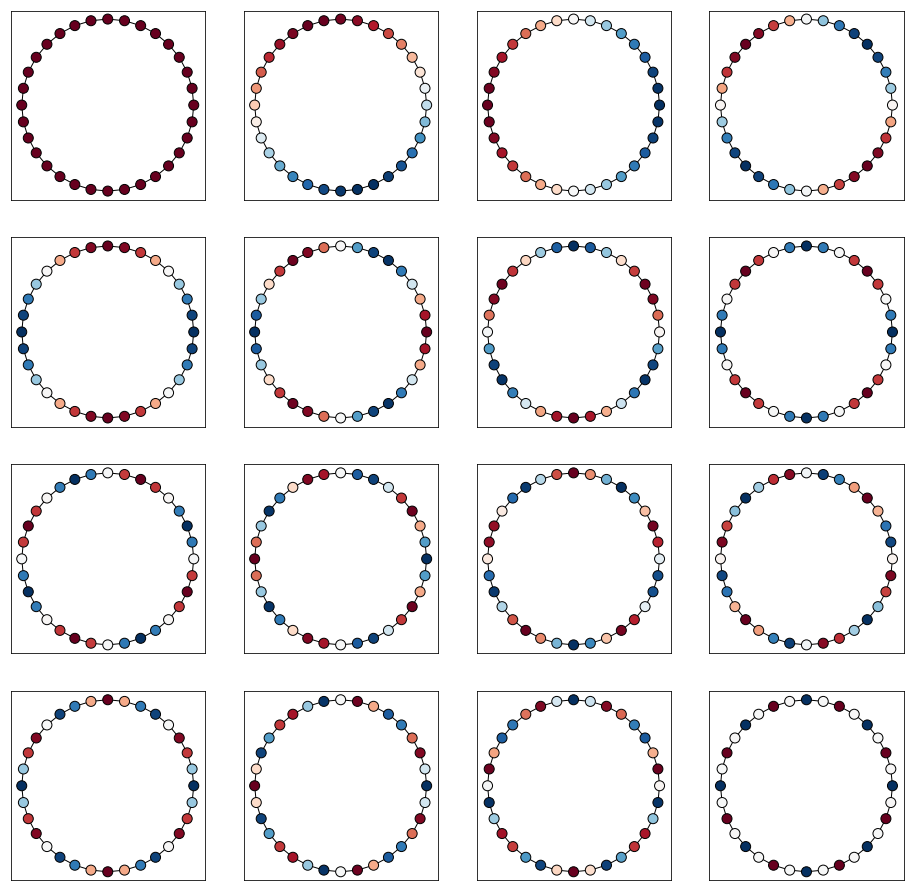

In [15]:
# Plot first n representation features over graph.
def plot_representation_features(rep_features, node_size=100, nrows=4, ncols=4):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 16))
    _ = plotting.plot_many_features(adj, xy, rep_features, nrows=nrows, ncols=ncols, axes=axes, 
                                    node_size=node_size, norm_per_feature=True)

plot_representation_features(rep_features, node_size=100, nrows=4, ncols=4)

If using `euclidean_gaussian` as the representation, visualize the centers of the selected Gaussians.

In [16]:
# Plot centers if applicable.
def plot_centers(centers, adj, xy, labels, node_size=10):
    _, ax = plt.subplots(1)
    plotting.plot_graph(adj, xy=xy, node_color=labels, ax=ax, node_size=10)
    ax.plot(centers[:, 0], centers[:, 1], '.')
    ax.set_title("Gaussian Center locations.")
    ax.axis("equal")
    
if rep_name == "euclidean_gaussian":
    plot_centers(centers, adj, xy, labels, node_size=10)

If using `laplacian_eig` as the representation, plot the eigenvalues for each eigenvector. Sometimes, these will vary very smoothly (e.g. line, ring, openroom), sometimes they will vary in a more step-wise fashion (tree, clique_ring, sbm). Sometimes there will be a unique eigenvector for each eigenvalue, other times there will be two or more eigenvectors with the same eigenvalue (check out the corresponding eigenvectors -- these often expose symmetries in the task).

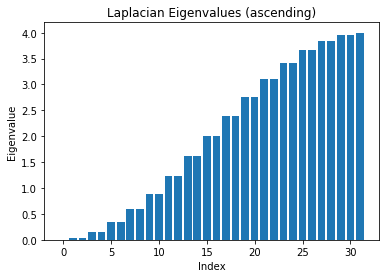

In [17]:
# Plot eigenvalues if applicable.
def plot_eigenvalues(evals):
    _, ax = plt.subplots(1)
    if np.any(np.imag(evals) != 0):
        print("Ignoring imaginary component of eigenvalues.")
    ax.bar(np.arange(len(evals)), np.real(evals))
    ax.set_ylabel("Eigenvalue")
    ax.set_xlabel("Index")
    ax.set_title("Laplacian Eigenvalues (ascending)")

if rep_name == "laplacian_eig":
    plot_eigenvalues(evals)

# Learn a value function
Here we will learn a value function by randomly exploring the specified environment using the selected representation. Note that the agent is learning the value of each representation feature dimension rather than learning the value of each state (unless rep_name=="onehot", in which the feature vector implicitly specifies a state). Because the agent is learning the value of each feature, learning will happen faster if the features capture a relevant commonality between states and value can "generalize" over this feature, and slower if many features are irrelevant. Learning may not be possible at all if important differences between states are not reflected by different feature representations. Experiment with different reward vectors to try and see when learning a reward function is facilitated by a certain representation, and when it is harder (for example, Euclidean Gaussians might be helpful for learning about reward that lives on both side of the wall in fourrooms environment, while random walk successor representation or Laplacian eigenvectors might be better if reward is only on one side of a boundary. As a followup exercise, You may also want to add some experiments that instantiates reward revaluation (relearning after the reward changes) or transition revaluation (relearning after the task graph changes) to see how the different representations support relearning.

Note that we're just learning the value function here, not implementing action-selection or control. This lets us explore how the reprsentation we have selected generalizes without considering the additional affect of policy improvement.

In [37]:
def train(adj, rep_features):
    """Learn a value function."""
    learning_rate = .01
    discount = .9
    n_states = len(adj)
    reward_ind = n_states - 1
    reward_vec = np.zeros((n_states, 1))
    reward_vec[reward_ind] = 1
    value = np.zeros((n_states, 1))
    current_state = 0
    transmat = util.l1_normalize_rows(adj)
    time_steps = 10000
    start_prob = np.ones(n_states)*1. / n_states
    
    # Ground truth value: conveys the value of each state given random walk policy and perfect
    #   knowledge of where reward is located in the environment.
    gt_value = np.dot(representations.successor_rep(transmat, discount)[0], reward_vec)

    states_visited = []
    reward_amts = []
    for t in range(time_steps):
        reward = reward_vec[current_state]
        next_state = rl.step(current_state, transmat)
        states_visited.append(next_state)
        value, weights = rl.value_update(
            reward=reward, value=value, current_state=current_state,
            next_state=next_state, learning_rate=learning_rate,
            discount=discount, features=rep_features)
        # Reward amount: estimates the amount of reward an agent would receive using a
        #   softmax-greedy policy given the current value function, assuming a uniform 
        #   probability of starting in every state (specified in start_prob). This serves
        #   as a way to assess the quality of the current value function.
        reward_amt = rl.reward_amt(value, reward_vec, adj, softmax_inv_temp=1.,
                                   discount=discount, start_prob=start_prob)
        reward_amts.append(reward_amt)
        current_state = next_state
        transmat = util.l1_normalize_rows(adj)
    return value, states_visited, reward_amts, gt_value, weights

t_start = time.time()
value, states_visited, reward_amts, gt_value, value_feature_weights = train(adj, rep_features)
t_end = time.time()
print("Time elapsed: {0:0.3f} sec".format(t_end - t_start))

Time elapsed: 5.987 sec


# Plot value weights on each feature
Recall that above, we learned a value function in "feature space," meaning we learned a weight for each feature. Here we'll plot the weight for each feature. If we are using the successor representation, this should look a lot like the reward vector since value V = SR matrix * R. If we are using laplacian eigenvectors, these will probably (but not always) decrease with feature.

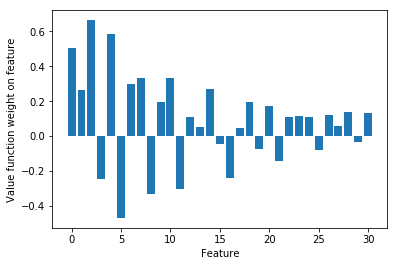

In [42]:
def plot_weights_in_rep_space(value_feature_weights):
    _, ax = plt.subplots(1)
    n = len(value_feature_weights)
    ax.bar(np.arange(n), value_feature_weights.reshape(-1))
    ax.set_xlabel("Feature")
    ax.set_ylabel("Value function weight on feature")
    
plot_weights_in_rep_space(value_feature_weights)

# Visualize the learned value function
Here we'll plot the value for each state that our learning process inferred. The top plot will show the value learned, and the bottom will show the estimated "ground truth" value estimated given perfect knowledge of the reward function.

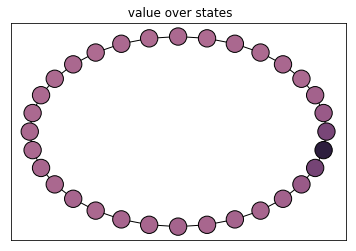

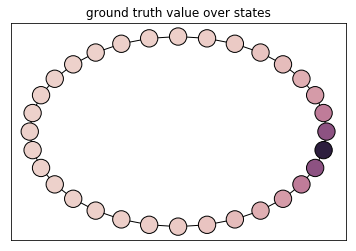

In [43]:
# Visualize new value
def visualize_value(adj, xy, value, value_name=""):
    _, ax = plt.subplots(1)
    cmap = sns.cubehelix_palette(1, as_cmap=True)
    plotting.plot_graph(adj, xy=xy, node_color=value.reshape(-1), cmap=cmap, ax=ax)
    ax.set_title("{} value over states".format(value_name))

visualize_value(adj, xy, value)
visualize_value(adj, xy, gt_value, value_name="ground truth")

# Visualize learning over time
To visualize a learning curve, we'll plot the expected reward_amts: the expected discounted future reward obtained by an agent using a softmax greedy policy given the current estimated value function. This serves as a way to have a scalar that assesses the quality of the value function at each point during learning.


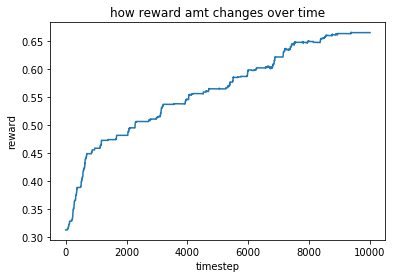

In [44]:
# Visualize rate of reward
def visualize_reward_obtained(reward_amts):
    _, ax = plt.subplots(1)
    ax.plot(reward_amts)
    ax.set_xlabel("timestep")
    ax.set_ylabel("reward")
    ax.set_title("how reward amt changes over time")
    
visualize_reward_obtained(reward_amts)

# Some other things to try out:
- Compare learning curves for different representations.
- Are there some reward vectors that work better/worse with different representations? Under what assumptions are some feature representations better or worse?
- Implement control with SARSA or Q-learning.
- Implement feature-based exploration as described (see slides), in which the agent selects a dimension of feature space to traverse (e.g. the eigenoption approach by [Machado *et al* 2017](https://arxiv.org/pdf/1703.00956.pdf))